In [1]:
from tl_tools import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
setup_mixed_precision()

Mixed precision policy set to: mixed_float16



In [2]:
resnet_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/resnet34v2.keras'
resnet34v2 = load_model(resnet_path)

2024-10-20 18:27:11.805159: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-20 18:27:11.805185: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-10-20 18:27:11.805189: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-10-20 18:27:11.805201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-20 18:27:11.805210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))
X_test, y_test = test_splits(test)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [4]:
pred = tf.argmax(resnet34v2.predict(X_test), axis = 1).numpy()
y_true = tf.argmax(y_test, axis=1).numpy()

2024-10-20 18:27:14.725271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step


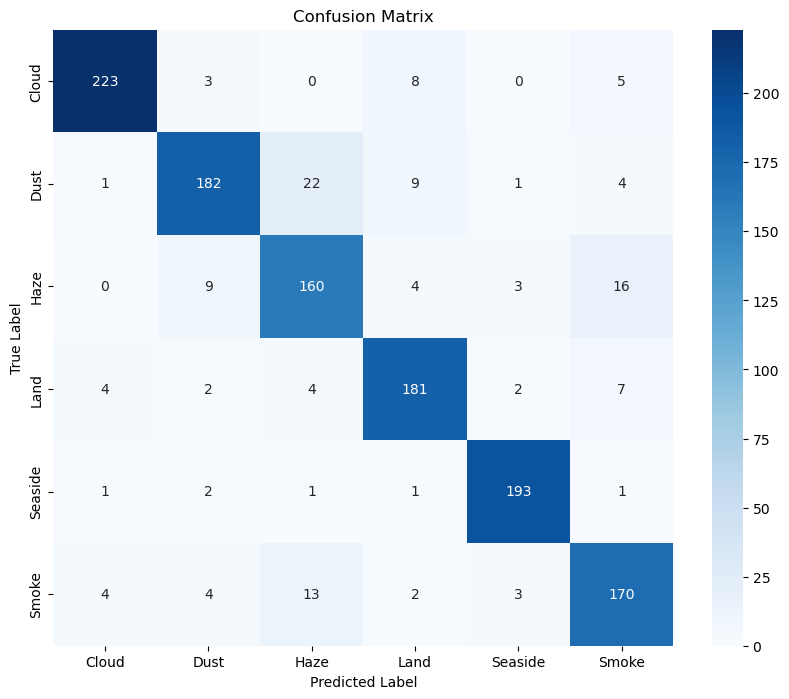

In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test.class_indices.keys())
confusion_matrix = confusion_matrix(pred, y_true)


plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [57]:
n_classes = len(class_labels)
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

metrics = ['Precision', 'Recall', 'F1-score', 'False Negative Rate']

df_metrics = pd.DataFrame(index=metrics, columns=class_labels)

for i in range(n_classes):
    df_metrics.iloc[0, i] = TP[i] / (TP[i] + FP[i])
    df_metrics.iloc[1, i] = TP[i] / (TP[i] + FN[i])
    df_metrics.iloc[2, i] = 2 * TP[i] / (2 * TP[i] + FP[i] + FN[i])
    df_metrics.iloc[3, i] = FN[i] / (FN[i] + TP[i])  # False Negative Rate

def round_fn(input): 
    return round(input, 4)

df_metrics = df_metrics.map(round_fn)
df_metrics

,Cloud,Dust,Haze,Land,Seaside,Smoke
Precision,0.9571,0.9010,0.8000,0.8829,0.9554,0.8374
Recall,0.9331,0.8311,0.8333,0.9050,0.9698,0.8673
F1-score,0.9449,0.8646,0.8163,0.8938,0.9626,0.8521
False Negative Rate,0.0669,0.1689,0.1667,0.0950,0.0302,0.1327


In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision = precision_score(pred, y_true, average= None).mean()
recall = recall_score(pred, y_true, average = None).mean()

print(f'Accuracy Score: {accuracy_score(pred, y_true):.4f}')
for index, row in df_metrics.iterrows(): 
    row_mean = row.mean()
    print(f'Average {index} Score: {row_mean:.4f}')

Accuracy Score: 0.8908
Average Precision Score: 0.8890
Average Recall Score: 0.8899
Average F1-score Score: 0.8891
Average False Negative Rate Score: 0.1101
